In [0]:
import cv2 as cv
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import pandas as pd
import pickle
import os

import keras.utils
from keras import backend as K

from keras.applications import mobilenet, resnet50, inception_resnet_v2, inception_v3, vgg16
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import dot, Dense, GlobalAveragePooling2D, Input, Lambda
from keras.models import Model
from keras.optimizers import RMSprop
from keras.regularizers import l2

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Siamese Pair / Triplet Generator

In [0]:
class SiamesePairGenerator(keras.utils.Sequence):

    def __init__(self, directory, idxs, labels, img_dict,
                 transform_gen = None,
                 dim = (224,224), n_channels = 3,
                 n_aug=1, batch_size = 32, shuffle = True, pair_type = 'pairs'):

        self.directory = directory
        self.idxs = idxs
        self.label_dict = labels
        self.img_dict = img_dict
        self.transform = transform_gen
        self.dim = dim
        self.channels = n_channels
        self.aug_factor = n_aug
        self.batch_size = batch_size
        self.shuffle = True
        self.on_epoch_end()
        self.pair_type = pair_type

    # shuffle indices at the end of each epoch
    def on_epoch_end(self):
        if self.shuffle is True:
            np.random.shuffle(self.idxs)
        # print(self.idxs[0])

    # return number of batches per epoch
    def __len__(self):
        #return int(np.floor(len(self.idxs)/self.batch_size))
        return int(np.floor(len(self.idxs)*self.aug_factor/self.batch_size))

    # load image from directory
    def __load_image(self, fn):

        # print(os.path.join(self.directory))
        img = cv.imread(filename=os.path.join(self.directory,fn), flags=0)
        img = cv.resize(src=img, dsize=self.dim, dst=img)
        img = np.array(img,dtype=np.float32) / 255
        img = np.stack((img, img, img), axis=-1)

        if self.transform is None:
            return img

        # augment original image once
        else:
            img = img.reshape((1,) + img.shape)

            aug_counter = 0
            for batch in self.transform.flow(x=img, batch_size=1):

                aug_counter += 1
                if aug_counter > 0:
                    return batch[0]


    def __gen_random_idx(self, start, end, curr):

        if(curr==start and curr!=end):
            r = random.choice(list(range(start+1,end+1)))
        elif(curr==end and curr!=start):
            r = random.choice(list(range(start,end)))
        elif(curr==start and curr==end):
            r = 0
        else:
            r = random.choice(list(range(start,curr))+list(range(curr+1,end+1)))

        return r


    '''1 to N pair generation'''

    # generate a batch of image pairs for a set of indices
    def __data_generation(self, idx):

        if self.pair_type == 'pairs':
            x = np.empty(shape=(self.batch_size, 2, 224,224, self.channels ),dtype=np.float32)
        elif self.pair_type == 'triplets':
            x = np.empty(shape=(self.batch_size, 3, 224, 224, self.channels), dtype=np.float32)

        y = np.empty(shape=(self.batch_size),dtype=int)

        # import database image corresponding to idx
        start_idx = np.min(self.idxs)
        end_idx = np.max(self.idxs)
        # print("Start Idx: %d " %start_idx)
        # print("End Idx: %d" %end_idx)

        class_idx = self.idxs[idx]
        class_id = self.label_dict[class_idx]
        class_img_list = self.img_dict[class_id]

        # db_fn = self.img_dict[class_id]
        # img_db = self.__load_image(db_fn)

        # load anchor image
        class_img_idx1 = random.choice(list(range(0, len(class_img_list))))
        img_db = self.__load_image(class_img_list[class_img_idx1])


        for i in range(0,self.aug_factor):

            # print("\nBatch Element: %d" % i)
            # print("\tImage 1: [%d,%s]: " % (class_idx, class_img_list[class_img_idx1]))

            # load positive image
            class_img_idx2 = self.__gen_random_idx(0, len(class_img_list) - 1, class_img_idx1)
            img_pos = self.__load_image(class_img_list[class_img_idx2])

            # load negative image
            random_idx = self.__gen_random_idx(0, len(self.idxs) - 1, idx)
            rand_class_id = self.label_dict[self.idxs[random_idx]]
            rand_img_list = self.img_dict[rand_class_id]
            rand_img_idx = random.choice(list(range(0, len(rand_img_list))))
            img_neg = self.__load_image(rand_img_list[rand_img_idx])

            if self.pair_type == 'pairs':
                # make a positive pair for even indices
                if i % 2 == 0:
                    y[i,] = 1
                    pair_img = img_pos
                    # print("\tImage 2: [%d,%s]: " % (class_idx, class_img_list[class_img_idx2]))

                # make a negative pair for odd indices
                else:
                    y[i,] = 0
                    pair_img = img_neg
                    # print("\tImage 2: [%d,%s]: " % (self.idxs[random_idx], rand_img_list[rand_img_idx]))

                x[i,] = np.array([[img_db, pair_img]], dtype=np.float32)

            elif self.pair_type == "triplets":
                # print("\tImage 2: [%d,%s]: " % (class_idx, class_img_list[class_img_idx2]))
                # print("\tImage 3: [%d,%s]: " % (self.idxs[random_idx], rand_img_list[rand_img_idx]))
                x[i,] = np.array([[img_db, img_pos, img_neg]], dtype=np.float32)

        return x, y


    # return batch of image data and labels
    def __getitem__(self, idx):

        # print("Current database idx: %d" %idx)
        # idxs = self.idxs[idx*self.aug_factor:(idx+1)*self.aug_factor]

        X, Y = self.__data_generation(idx)

        return X, Y

## Import Whale Database

In [0]:
# open bbox annotation csv file
data_dir = "/storage/data/humpback-whale-challenge/"
train_dir = "train"
csv_file = "train.csv"
df = pd.read_csv(filepath_or_buffer=os.path.join(data_dir,csv_file))

# create dictionaries mapping class idx to class id and class id to img filenames
unique_ids = df["Id"].unique()
db_dict = dict({})
img_dict = dict({})

counter = 0
for id in unique_ids:

    # exclude new_whale from db
    if id != 'new_whale':

        id_df = df[df['Id'] == id]
        img_fns = id_df['Image'].tolist()

        if len(img_fns) > 0:
            db_dict[counter] = id
            img_dict[id] = img_fns
            counter+=1

print("# of unique whale IDs: %d" %len(db_dict))

# of unique whale IDs: 4250


## Visualize Train/ Val Images

In [0]:
def show_image_pairs(batch_imgs, labels, nrows=2, ncols=6):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

    for i in range(0,batch_imgs.shape[0]):

        img1 = batch_imgs[i][0]
        img2 = batch_imgs[i][1]

        axes[0,i].imshow(img1)
        axes[1,i].imshow(img2)

        title = "Pair "+str(i) + ", Lbl = " + str(labels[i])
        axes[0,i].set_title(title)
        axes[1,i].set_title(title)


    plt.show()

def show_triplets(batch_imgs, nrows=3, ncols=6):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

    for i in range(0,batch_imgs.shape[0]):

        img1 = batch_imgs[i][0]
        img2 = batch_imgs[i][1]
        img3 = batch_imgs[i][2]

        axes[0,i].imshow(img1)
        axes[1,i].imshow(img2)
        axes[2,i].imshow(img3)

        title1 = "Triplet "+str(i) + ", Anchor"
        title2 = "Triplet " + str(i) + ", Positive"
        title3 = "Triplet " + str(i) + ", Negative"
        axes[0,i].set_title(title1)
        axes[1,i].set_title(title2)
        axes[2,i].set_title(title3)


    plt.show()

## Create Train / Val Generators

# of training batches: 3825
# of validation batches: 425
(32, 2, 224, 224, 3)


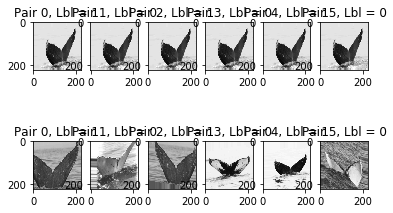

In [0]:
n_split = 0.9
db_idxs = list(db_dict.keys())
random.shuffle(x=db_idxs)
cutoff_idx = int(len(db_idxs)*n_split)
train_idxs = db_idxs[0:cutoff_idx]
val_idxs = db_idxs[cutoff_idx:len(db_idxs)]

# print(val_idxs)
# print("\nTrain indices: %s" +str(train_idxs))
# print("\nVal indices: %s" +str(val_idxs))

train_transforms = ImageDataGenerator(width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.25,
                                   shear_range=10,
                                   horizontal_flip=True)


train_gen = SiamesePairGenerator(directory=os.path.join(data_dir,train_dir),
                                 idxs=train_idxs,
                                 labels=db_dict,
                                 img_dict=img_dict,
                                 transform_gen=train_transforms,
                                 n_aug=32,
                                 pair_type='pairs')

val_gen = SiamesePairGenerator(directory=os.path.join(data_dir,train_dir),
                               idxs=val_idxs,
                               labels=db_dict,
                               img_dict=img_dict,
                               transform_gen=None,
                               n_aug=32,
                               pair_type='pairs')

print("# of training batches: %d" %len(train_gen))
print("# of validation batches: %d" %len(val_gen))

train_imgs, train_labels = train_gen[0]
val_imgs, val_labels = val_gen[0]
print(train_imgs.shape)
# print(val_imgs.shape)
show_image_pairs(train_imgs[0:6], train_labels)
# show_image_pairs(val_imgs[0:8],ncols=8)
# show_triplets(train_imgs[0:6])

## Create Encodings

In [0]:
# load pre-trained base network
def load_base_model(input_shape, base_id):

    # Inception-v3
    if base_id is 0:
        base = inception_v3.InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)
        base_name = 'Inception-V3'

    # MobileNet
    elif base_id is 1:
        base = mobilenet.MobileNet(input_shape=input_shape, weights='imagenet', include_top=False)
        base_name = 'MobileNet'

    # Inception-ResNet-v2
    elif base_id is 2:
        base = inception_resnet_v2.InceptionResNetV2(input_shape=input_shape, weights='imagenet', include_top=False)
        base_name = 'InceptionResNet-v2'

    # ResNet50
    elif base_id is 3:
        base = resnet50.ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
        base_name = 'ResNet50'

    # VGG16
    elif base_id is 4:
        base = vgg16.VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
        base_name = 'VGG16'

    print("\nBase Network: %s" % base_name)

    top = GlobalAveragePooling2D()(base.output)

    # freeze all layers in the base network
    for layers in base.layers:
        layers.trainable = False

    model = Model(inputs=base.input, outputs=top, name='base_model')

    return model

base_id = 4 # 0 = Inception-v3, 1 = MobileNet, 2 = Inception-ResNet-v2, 3= ResNet50, 4=VGG16
input_shape = (224,224,3)
base_model = load_base_model(input_shape=input_shape, base_id=base_id)


Base Network: VGG16


In [0]:
# generates a (2, N, 1) encoding array for two input images
def create_pair_encoding_model(base,input_shape):

    input_pair = Input(shape=input_shape, name='input_pair')

    input_a = Lambda(function=lambda x:x[:,0], name='input_a')(input_pair)
    input_b = Lambda(function=lambda x:x[:,1], name='input_b')(input_pair)

    encoding_a = base(input_a)
    encoding_b = base(input_b)
    
    output_pair = Lambda(function=lambda x: K.stack(x=[x[0],x[1]],axis=1), name='output_pair')([encoding_a, encoding_b])
    model = Model(inputs=input_pair, outputs=output_pair, name='encoding_pair_model')

    return model

# generates a (3, N, 1) encoding array for two input images
def create_triplet_encoding_model(base,input_shape):

    input_triplet = Input(shape=input_shape, name='input_pair')

    input_anchor = Lambda(function=lambda x:x[:,0], name='input_anchor')(input_pair)
    input_pos = Lambda(function=lambda x:x[:,1], name='input_pos')(input_pair)
    input_neg = Lambda(function=lambda x:x[:,2], name='input_neg')(input_pair)

    encoding_anchor = base(input_anchor)
    encoding_pos = base(input_pos)
    encoding_neg = base(input_neg)
    
    output_triplet = Lambda(function=lambda x: K.stack(x=[x[0],x[1], x[2]],axis=1), 
                            name='output_pair')([encoding_anchor, encoding_pos, encoding_neg])
    
    model = Model(inputs=input_triplet, outputs=output_triplet, name='encoding__triplet_model')

    return model

pair_type = 0 # 0=pairs, 1=triplets

if pair_type is 0:
  pair_shape = (2,224,224,3)
  encoding_model = create_pair_encoding_model(base_model,pair_shape)
elif pair_type is 1:
  pair_shape = (3,224,224,3)
  encoding_model = create_triplet_encoding_model(base_model,pair_shape)

In [0]:
print("\nCreating val encodings")
x_val_encoding = encoding_model.predict_generator(generator=val_gen, steps=len(val_gen), verbose=1)
print("x_val: "+str(x_val_encoding.shape))


Creating val encodings
425/425 [==============================] - 241s 567ms/step
x_val: (13600, 2, 512)


In [0]:
print("\nCreating train encodings")
x_train_encoding = encoding_model.predict_generator(generator=train_gen, steps=len(train_gen), verbose=1)
print("x_train: "+str(x_train_encoding.shape))


Creating train encodings
3825/3825 [==============================] - 3511s 918ms/step
x_train: (122400, 2, 512)


## Save Train / Val Encodings

In [0]:
print("x_train size: " +str(x_train_encoding.nbytes/1e9))
print("x_val size: " +str(x_val_encoding.nbytes/1e9))

with open('x_train_pairs_vgg.pickle', 'wb') as f:
        pickle.dump(obj=x_train_encoding, file=f, protocol=pickle.HIGHEST_PROTOCOL)

with open('x_val_pairs_vgg.pickle', 'wb') as f:
        pickle.dump(obj=x_val_encoding, file=f, protocol=pickle.HIGHEST_PROTOCOL)


x_train size: 0.5013504
x_val size: 0.0557056


In [0]:
with open('x_train_pairs_vgg.pickle', 'rb') as f:
    temp1 = pickle.load(file=f)
    
with open('x_val_pairs_vgg.pickle', 'rb') as f:
    temp2 = pickle.load(file=f)
    
print(temp1.shape)
print(temp2.shape)

(122400, 2, 512)
(13600, 2, 512)
